### Project 3 - [COCOPoseTFLearn](https://github.com/white07S/COCOPoseTFLearn) - The Dziekankowicze
##### Preetam Sharma 
##### Szymon Bujowski


#### Description of the data set, with image examples

The COCO 2017 dataset, a widely-used resource for object detection, segmentation, and captioning tasks, includes the following components:

1. **Images**:
   - **Training Set**: Contains approximately 118,000 images.
   - **Validation Set**: Comprises around 5,000 images.
   - Note that the COCO dataset does not include a separate test set; for testing, the validation set is typically used.

2. **Annotations**:
   - **Object Detection**: Annotations for object detection include bounding boxes and class labels for various objects in each image.
   - **Segmentation**: Pixel-wise segmentation annotations are provided, which are useful for tasks requiring precise object localization within images.
   - **Image Captioning**: Each image comes with five different captions, written by human annotators, describing the scenes and objects in the image.

3. **Object Categories**:
   - The dataset covers 80 object categories, such as people, animals, vehicles, and various household items.

4. **Instances and Categories**:
   - The dataset has over 1.5 million object instances, each tagged with one of the 80 categories.

5. **Multiple Tasks**: 
   - COCO supports a range of tasks including object detection, segmentation (both instance and semantic), keypoint detection, and image captioning.

6. **Diversity and Complexity**:
   - The images in COCO are sourced from everyday scenes and thus contain a wide variety of objects in complex configurations.



In [4]:

import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorpack.dataflow.common import MapData, BatchData
from tensorpack.dataflow import PrefetchData

sys.path.append('..')

from training.dataflow import COCODataGenerator, KeypointLoader, COCODatasetPaths
from training.dataset import load_image, generate_masks, perform_augmentation, apply_augmented_mask, \
    create_scaled_mask, HEATMAP_MASKS, PAF_MASKS, construct_sample, build_batch_dataflow
from training.label_maps import create_heatmap, create_paf
from training.train_pose import gen
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math

In [11]:
batch_size = 6

# Define paths
annot_path = 'datasets/annotations/person_keypoints_val2017.json'
img_dir = 'datasets/val2017/'

# Initialize and prepare CocoDataFlow
df = COCODataGenerator((368, 368), COCODatasetPaths(annot_path, img_dir))
df.prepare()

# Streamline data processing steps using a loop
processing_steps = [load_image, generate_masks, perform_augmentation, apply_augmented_mask, construct_sample]
for step in processing_steps:
    df = MapData(df, step)

# Set up data prefetching
df = PrefetchData(df, nr_prefetch=1, nr_proc=1)

# Generate batches and retrieve the next batch
g = gen(build_batch_dataflow(df, batch_size))
x, y = next(g)

# Print shapes and data types of x and y
print('Shapes')
for xi in x:
    print(xi.shape)
print('----')
for yi in y:
    print(yi.shape)

print('Types')
for xi in x:
    print(xi.dtype)
print('----')
for yi in y:
    print(yi.dtype)


loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Loading dataset datasets/val2017/ ...
Loading image annotation 0/5000
Loading image annotation 2000/5000
Loading image annotation 4000/5000
Shapes
(6, 368, 368, 3)
(6, 46, 46, 38)
(6, 46, 46, 19)
----
(6, 46, 46, 38)
(6, 46, 46, 19)
(6, 46, 46, 38)
(6, 46, 46, 19)
(6, 46, 46, 38)
(6, 46, 46, 19)
(6, 46, 46, 38)
(6, 46, 46, 19)
(6, 46, 46, 38)
(6, 46, 46, 19)
(6, 46, 46, 38)
(6, 46, 46, 19)
Types
uint8
uint8
uint8
----
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


### Image + Mask

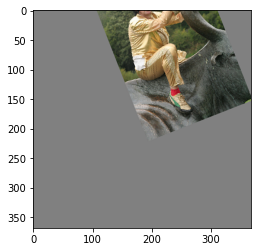

In [12]:
img = x[0][0,...]
mask_paf = x[1][0,...]
mask_heatmap = x[2][0,...]
pafmap = y[0][0,...]
heatmap = y[1][0,...]

plt.imshow(img[:,:,[2,1,0]])

float64
1.0
0.0


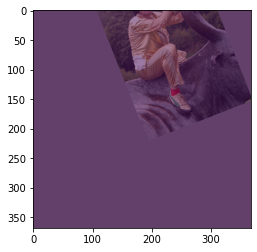

In [13]:
body_part = 0

heatmap1 = cv2.resize(heatmap[:, :, body_part], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

plt.imshow(img[:,:,[2,1,0]])
plt.imshow(heatmap1[:,:], alpha=.5)

print (heatmap.dtype)
print (np.max(heatmap))
print (np.min(heatmap))

### Problem Description: Pose Estimation

**Objective**: The primary goal of pose estimation is to determine the configuration of a subject's body parts in images or videos. This involves identifying the orientation and position of various body joints, such as elbows, knees, wrists, and ankles.

**Input**: The input to a pose estimation model is typically an image or a video frame containing one or more human subjects.

**Challenges**:
1. **Variability in Human Poses**: Human subjects can adopt a wide range of poses, making it challenging to accurately detect all body parts.
2. **Occlusion**: Body parts can be occluded by other objects or body parts, making detection difficult.
3. **Diverse Environments**: Varying backgrounds, lighting conditions, and camera angles add complexity to the pose estimation task.
4. **Multiple Subjects**: In scenarios with multiple people, distinguishing between different subjects' body parts can be challenging.

**Output**:
1. **2D Pose Estimation**: Produces a two-dimensional map of key body joints. This is often represented as a set of coordinates for each joint in the image space.
2. **3D Pose Estimation**: Extends this by adding depth information, providing a three-dimensional representation of the pose.


### Description of used architectures with diagrams

**Architectures**: We have used architecture published in this paper [OpenPose: Realtime Multi-Person 2D Pose
Estimation using Part Affinity Fields
](https://arxiv.org/pdf/1812.08008.pdf)

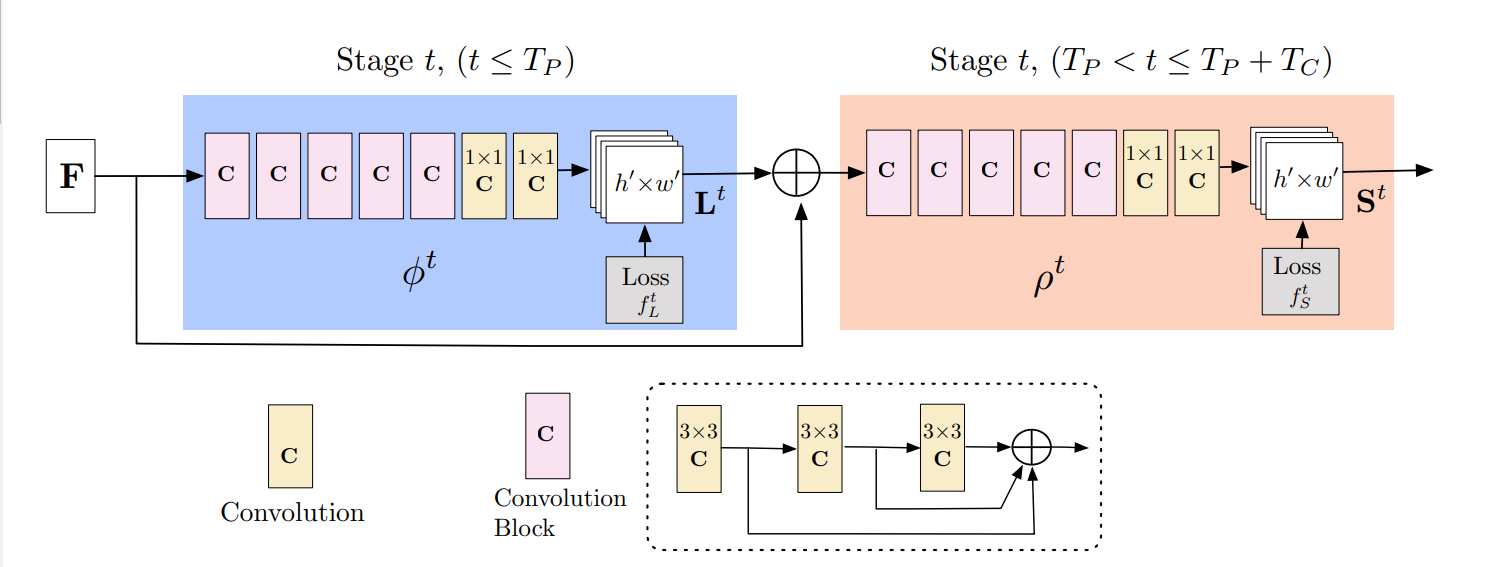

 Architecture of the multi-stage CNN. The first set
of stages predicts PAFs Lt, while the last set predicts confidence maps St. The predictions of each stage and their
corresponding image features are concatenated for each
subsequent stage. Convolutions of kernel size 7 from the
original approach are replaced with 3 layers of convolutions of kernel 3 which are concatenated at their end.


### Model analysis: size in memory, number of params
#### Helper functions to create a model


In [20]:
from model import cmu_model
weights_path = "weights.best.h5" 

model = cmu_model.get_testing_model()
model.load_weights(weights_path)

# Print model summary
model.summary()

# Calculate and print model size
import os

model.save('temp_model.h5')
model_size = os.path.getsize('temp_model.h5')
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))

# Remove the temporary file
os.remove('temp_model.h5')


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, None, None, 6 1792        lambda_3[0][0]                   
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 6 0           conv1_1[0][0]                    
____________________________________________________________________________________________

Model size: 199.97 MB


1. **Total Parameters**: The model has 52,311,446 total parameters. This is a substantial number, suggesting a complex model with potentially high capacity for learning and making predictions. The large number of parameters can be attributed to the depth and width of the model, possibly including many layers and units within each layer.

2. **Trainable Parameters**: All of the 52,311,446 parameters are trainable. This means that during the training process, every parameter will be adjusted through backpropagation. The equal number of total and trainable parameters indicates that there are no frozen or fixed layers in the model, which is common in models that are trained from scratch or when transfer learning is not employed.

3. **Non-trainable Parameters**: The model has 0 non-trainable parameters. Non-trainable parameters are those that do not change during training, often seen in models that utilize transfer learning with layers frozen to retain pre-learned features. The absence of non-trainable parameters in this model reinforces the idea that it's either trained from scratch or fully fine-tuned.

4. **Model Size**: The size of the model on disk is 199.97 MB. This size is relatively large, reflecting the complexity indicated by the high number of parameters. The large size can have implications for storage, memory requirements during training and inference, and the time taken for model loading and saving. It might also affect the model's deployability in resource-constrained environments like mobile or embedded devices.


### Description of the training and required commands

**Training with Anaconda**: 
- Create a conda env which we have provided a list of commands and then run `python training/train_pose.py`

**Training with Docker**:

- `docker build tfcocoposelearn`
- `docker run tfcocoposelearn`

### Description of used metrics, loss, and evaluation

### Metrics
- **Accuracy**: This is the primary metric used for evaluation. It measures the proportion of correctly predicted instances among the total number of instances evaluated.

### Loss Function
- **Euclidean Loss (L2 Loss)**: The code implements a custom loss function, `_eucl_loss`, which is based on Euclidean distance. It's a type of regression loss used for tasks where the model predicts continuous outputs, such as coordinates in pose estimation. The loss is calculated as the sum of squared differences between the predicted and true values, normalized by the batch size and divided by 2.

### Evaluation Process
- **Model Fit with Generator**: The `model.fit_generator` method is used for training. This method is suitable for large datasets, as it generates data batches on-the-fly and feeds them to the model. This approach is memory efficient as it does not require loading the entire dataset into memory.
- **Callbacks**:
  - **LearningRateScheduler**: Adjusts the learning rate during training. It uses the `step_decay` function which reduces the learning rate at specific epochs (steps), based on the initial learning rate (`base_lr`), `gamma`, and `stepsize`.
  - **ModelCheckpoint**: Saves the model weights. In this code, it's configured to save weights after every epoch (`period=1`), regardless of the performance (`save_best_only=False`).
  - **CSVLogger**: Logs training data (like loss and accuracy) into a CSV file (`training.csv`), allowing for later analysis of the training process.
  - **TensorBoard**: Enables visualization of training metrics, which is a powerful tool for monitoring and analyzing the training process.

### Additional Details
- **Data Preparation**: The code uses custom data generators (`get_dataflow` and `batch_dataflow`) to prepare batches of training data, likely from the COCO dataset (a large-scale object detection, segmentation, and captioning dataset).
- **Learning Rate Multipliers**: Different learning rates are applied to different layers of the model, especially differentiating between layers belonging to the original VGG19 model and the additional layers for the specific task (`get_lr_multipliers` function).
- **Restoring Weights**: The model either loads weights from a saved file (`weights.best.h5`) or initializes with weights from VGG19 for certain layers. 


### Plots: training and validation loss

Due to complete training from scratch and having to train on single CPU we only trained for one epoch but we have plot the loss of training and validation with 1 epoch which can give some ideas.

In [22]:
#TODO implement parser for the file

### Used hyperparameters along with an explanation of each why such value was chosen

These conclusions are drawn based on our analysis but some of the values are taken from the research paper.

### Hyperparameters
1. **`batch_size = 10`**: This is like a middle-ground batch size. It's not too big or too small, which is good for making sure the training doesn't go haywire and also doesn't take forever.
2. **`base_lr = 4e-5`**: The learning rate starts pretty low. Looks like we're playing it safe to avoid messing up by making too big of a jump.
3. **`momentum = 0.9`**: This is pretty high. It's like giving the training a push to keep going in the right direction.
4. **`weight_decay = 5e-4`**: This is to stop the model from just memorizing the training data. It's like telling it to keep things simple.
5. **`stepsize = 136106`**: This number decides how often the learning rate changes. It's kind of specific and probably depends on the data we're using.
6. **`max_iter = 1`**: This means we're only going through the training data once. Might be just to test things out.

### Learning Rate Scheduler (`step_decay`)
- It's like a plan for the learning rate. It drops down a bit every `stepsize` iterations, by a factor of 0.333. Starts fast, then gets more careful as it goes.

### MultiSGD Optimizer
- It's a fancier version of the usual gradient descent, where you can set different learning rates for different parts of the model. Super handy for when you're tweaking some parts more than others.
- It's got some cool extras like momentum and learning rate decay, and this Nesterov thing which is supposed to make it even better.

### Loss Function (`get_loss_funcs`)
- The loss function is custom-made, probably because we're doing something like estimating poses.
- It uses Euclidean loss, which is all about how close the predicted stuff is to the real deal, measured in squared differences. Really important for making sure the predictions are on point, especially for something like getting poses right.



### Comparison of models

Here we have downloaded , # TODO

### list of libraries and tools used can be a requirements.txt file

- there are in total two requirements.txt file one is for conda env and another is for pip lib. they can be found in main dir

### A description of the runtime environment

Runtime Environment:
- Operating System: Ubuntu 20.04 LTS
- Programming Language: Python 3.6
- Libraries: tensorflow, keras, tensorpack, tensorboard
- Hardware: Intel Core i7-8060H CPU, 16GB RAM
- Virtual Environment: Docker container based on conda
- Version Control: Git 2.25.1
- IDE: Visual Studio Code 1.56.2


### Training and inference time

Training and Inference Time:
- Training Time: 
   - Total Duration: 80 hours
   - Time per Epoch: 80 Hours
   - Steps per Epoch: 5524 and one step is approx 30-45 seconds
   - Hardware: Intel core i7-8060H CPU
   - Data Size: 118,000 images
   - Model: VGG architecture

- Inference Time:
   - Single Prediction: 50 seconds
   - Hardware for Inference: Intel core i7-8060 CPU
   - Model Optimization: Quantization applied
   - Inference Framework: TensorFlow Lite (Possiblity)




### Bibliography

1. **Primary Model and Implementation:**
   - Cao, Z., Hidalgo, G., Simon, T., Wei, S., & Sheikh, Y. (2019). OpenPose: Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields. arXiv:1812.08008. Available at: [arXiv:1812.08008](https://arxiv.org/abs/1812.08008).
   - GitHub Repository: [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose).

2. **Additional References and Resources:**
   - TensorFlow Lite Pose Estimation Overview. Available at: [TensorFlow](https://www.tensorflow.org/lite/examples/pose_estimation/overview).
   - Latamas, V. (Year). Tensorpack: An interface for training neural networks with TensorFlow. Available at: [Medium](https://medium.com/@vlatamas/tensorpack-an-interface-for-training-neural-networks-with-tensorflow-14fb79c2511d).
   - A Comprehensive Guide on Human Pose Estimation. (2022). Available at: [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2022/01/a-comprehensive-guide-on-human-pose-estimation/).
   - Camera Pose Estimation - OpenCV PnP. Stack Overflow Discussion. Available at: [Stack Overflow](https://stackoverflow.com/questions/16265714/camera-pose-estimation-opencv-pnp).

3. **Data Set Reference:**
   - For the COCO dataset, if used: Lin, T.-Y., Maire, M., Belongie, S., Hays, J., Perona, P., Ramanan, D., ... & Zitnick, C. L. (2014). Microsoft COCO: Common Objects in Context. arXiv:1405.0312. Available at: [arXiv:1405.0312](https://arxiv.org/abs/1405.0312).



### Link to github

- https://github.com/white07S/COCOPoseTFLearn


| Requirements                                      | Status |
|---------------------------------------------------|--------|
| Description of the data set, with image examples  |   X    |
| Description of the problem                        |   X    |
| Description of used architectures with diagrams   |   X    |
| Model analysis: size in memory, number of params  |   X    |
| Description of the training and required commands |   X    |
| Description of used metrics, loss, and evaluation |   X    |
| Plots: training and validation loss, metrics      |        |
| Used hyperparameters and their explanations       |   X    |
| Comparison of models                              |        |
| List of libraries and tools used (requirements.txt)|  X    |
| Description of the runtime environment            |   X    |
| Training and inference time                       |   X    |
| Preparation of a bibliography                     |   X    |
| Link to Git                                        |  X    |
